# <center> DataLab Cup 4 : Unlearnable Dataset </center>
## <center>Neural Tangent Generalization Attacks (NTGA)</center>

In [4]:
# !pip install tensorflow-addons

### import Library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

BATCH_SIZE = 64

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
x_train = np.load('./dataset/x_train_cifar10_unlearn.npy')
y_train = np.load('./dataset/y_train_cifar10.npy')
x_val = np.load('./dataset/x_val_cifar10.npy')
y_val = np.load('./dataset/y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

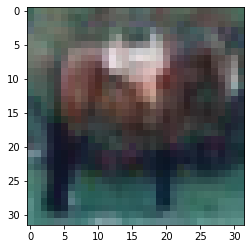

In [5]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

### Model - DenseNet121

In [6]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [9]:
# # DenseNet121 (from competition 2 & change units from 1024 to 128)

# IMAGE_SIZE = 32
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# densenet121 = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights=None ,classes=10)
# densenet121.trainable = False

# inputs = keras.Input(shape=input_shape)
# x = densenet121(inputs, training=False)

# x = conv_leaky_relu(x, 128, 3, 1)
# x = conv_leaky_relu(x, 128, 3, 1)

# x = layers.Flatten()(x)
# x = layers.Dense(128)(x)
# x = layers.LeakyReLU(0.1)(x)
# outputs = layers.Dense(units=128, activation='softmax')(x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
# model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         1179776   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1, 1, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 128)         147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1, 1, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               

In [7]:
# DenseNet121 (turn softmax to relu & dense 10)

IMAGE_SIZE = 32
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

densenet121 = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights=None ,classes=10)
densenet121.trainable = False

inputs = keras.Input(shape=input_shape)
x = densenet121(inputs, training=False)

x = conv_leaky_relu(x, 128, 3, 1)
x = conv_leaky_relu(x, 128, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
model.summary()

#   layers.Dense(128, activation='relu'),
#   layers.Dense(10)

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         1179776   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 1, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               

In [8]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [15]:
# denseNet v3
# history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=50) 

Epoch 1/50
625/625 [==============================] - 31s 44ms/step - loss: 2.1171 - acc: 0.1888 - val_loss: 1.9062 - val_acc: 0.2535
Epoch 2/50
625/625 [==============================] - 26s 41ms/step - loss: 1.9634 - acc: 0.2418 - val_loss: 1.8771 - val_acc: 0.2622
Epoch 3/50
625/625 [==============================] - 26s 41ms/step - loss: 1.9192 - acc: 0.2596 - val_loss: 1.8475 - val_acc: 0.2948
Epoch 4/50
625/625 [==============================] - 26s 42ms/step - loss: 1.8814 - acc: 0.2817 - val_loss: 1.8254 - val_acc: 0.3034
Epoch 5/50
625/625 [==============================] - 27s 43ms/step - loss: 1.8549 - acc: 0.2949 - val_loss: 1.7821 - val_acc: 0.3199
Epoch 6/50
625/625 [==============================] - 26s 42ms/step - loss: 1.8320 - acc: 0.3068 - val_loss: 1.7528 - val_acc: 0.3336
Epoch 7/50
625/625 [==============================] - 26s 41ms/step - loss: 1.8049 - acc: 0.3227 - val_loss: 1.7551 - val_acc: 0.3354 0s - loss: 1.8049 - acc: 0.322
Epoch 8/50
625/625 [===========

In [10]:
# denseNet v3
# 結論: epoch 50 就夠了，更高 epochs val_acc 也上不來
# history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=200) 

Epoch 1/200
625/625 [==============================] - 34s 43ms/step - loss: 2.1566 - acc: 0.1862 - val_loss: 1.9506 - val_acc: 0.2625
Epoch 2/200
625/625 [==============================] - 26s 42ms/step - loss: 2.0113 - acc: 0.2368 - val_loss: 1.8964 - val_acc: 0.2671
Epoch 3/200
625/625 [==============================] - 26s 41ms/step - loss: 1.9639 - acc: 0.2517 - val_loss: 1.8631 - val_acc: 0.2843
Epoch 4/200
625/625 [==============================] - 26s 41ms/step - loss: 1.9252 - acc: 0.2717 - val_loss: 1.8399 - val_acc: 0.2950
Epoch 5/200
625/625 [==============================] - 26s 42ms/step - loss: 1.8874 - acc: 0.2887 - val_loss: 1.8509 - val_acc: 0.2911
Epoch 6/200
625/625 [==============================] - 26s 41ms/step - loss: 1.8528 - acc: 0.3051 - val_loss: 1.8782 - val_acc: 0.2898
Epoch 7/200
625/625 [==============================] - 26s 42ms/step - loss: 1.8283 - acc: 0.3142 - val_loss: 1.8366 - val_acc: 0.3027
Epoch 8/200
625/625 [==============================] - 

### Property of NTGA

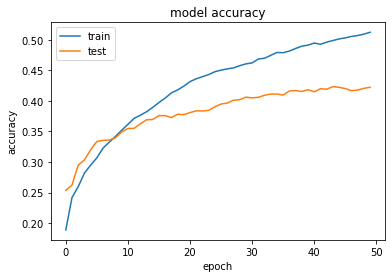

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [56]:
x_test = np.load('./dataset/x_test_cifar10.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [57]:
print(len(x_test))
print(len(test_dataset))
print(len(batched_test_dataset))

10000
10000
157


In [58]:
result = model.predict(x=batched_test_dataset)

In [59]:
len(result)

10000

In [62]:
result.shape

(10000, 10)

In [73]:
result

array([[-0.04393432, -0.0798047 , -0.24327485, ...,  0.00127435,
        -0.14885293,  0.02855207],
       [-0.04837721, -0.04913528, -0.22698417, ...,  0.0193783 ,
        -0.16397434,  0.06568741],
       [ 0.02019629,  0.02319831, -0.17241439, ...,  0.05608439,
        -0.11866691, -0.05888293],
       ...,
       [-0.02380493, -0.01708651, -0.3738721 , ...,  0.01836943,
        -0.20118186,  0.08057974],
       [-0.0203372 , -0.02627284, -0.24384463, ...,  0.01238948,
        -0.15801382,  0.05590353],
       [-0.0048778 , -0.02825364, -0.22971855, ...,  0.00985257,
        -0.18000358,  0.05708458]], dtype=float32)

In [77]:
final_result = np.argmax(result, axis=1)
final_result

array([3, 9, 3, ..., 9, 3, 3], dtype=int64)

In [78]:
output = pd.DataFrame({'id':range(len(final_result)), 'label':final_result})
output.to_csv('./output/output.csv', header=True, index=False)